In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - investigate_dr16_selection.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
# 
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Investigate the different methods for selecting a DR16 sample
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
%run ../../src/_helpers/basic_imports.py

## Plotting
import matplotlib.path as mpltPath

## Galpy
from galpy import orbit
from galpy import potential

## Astropy
from astropy import units as apu
from astropy.io import fits

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.linear_model

Basic imports...
numpy as np, pdb, sys, os, copy, glob, subprocess,
matplotlib.pyplot as plt, matplotlib as mpl, astropy.units as apu


In [3]:
# Matplotlib for notebooks
%matplotlib inline
plt.style.use('jl_notebook')
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

## Keywords and Data

In [4]:
n_bs = 100
ro=8
vo=220

In [29]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dr16_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data
data['PHI'][ np.where( data['PHI']>np.pi )[0] ] -= 2*np.pi
data_orbits = orbit.Orbit(np.array([data['R']/ro,
                                    data['VR']/vo,
                                    data['VT']/vo,
                                    data['Z']/ro,
                                    data['VZ']/vo,
                                    data['PHI']
                                    ]).T, ro=ro, vo=vo)

In [6]:
# derived parameters, this might take awhile
zmax = data_orbits.zmax(analytic=True, pot=potential.MWPotential2014, type='staeckel')

/Users/JamesLane/Software/Python/miniconda3/lib/python3.7/site-packages/galpy/util/bovy_coords.py:1894: RuntimeWarning: overflow encountered in sinh
  R= delta*sc.sinh(u)*sc.sin(v)

/Users/JamesLane/Software/Python/miniconda3/lib/python3.7/site-packages/galpy/util/bovy_coords.py:1895: RuntimeWarning: overflow encountered in cosh
  z= delta*sc.cosh(u)*sc.cos(v)

/Users/JamesLane/Software/Python/miniconda3/lib/python3.7/site-packages/galpy/actionAngle/actionAngleStaeckel.py:368: RuntimeWarning: invalid value encountered in add
  e= (rap-rperi)/(rap+rperi)



In [7]:
zmax.shape

(129237,)

# First show the properties of the whole sample

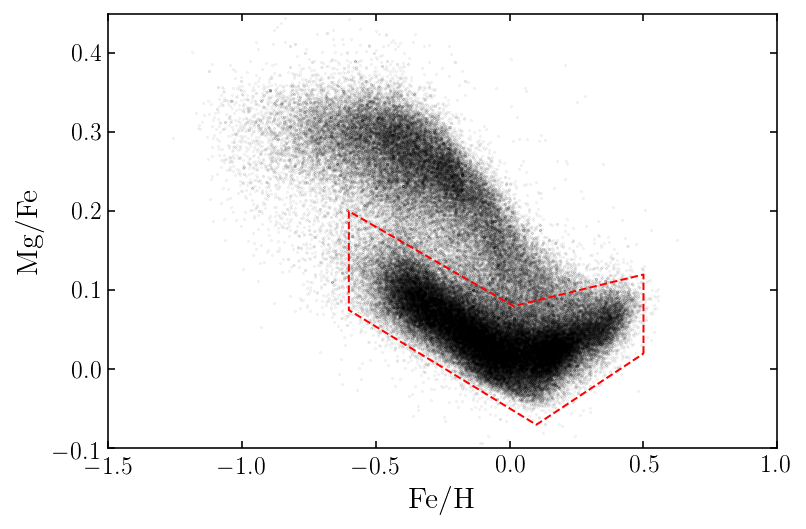

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( data['FE_H'], data['MG_FE'], s=0.1, alpha=0.1, c='Black')
ax.set_xlim(-1.5,1)
ax.set_ylim(-0.1,0.45)
ax.set_xlabel('Fe/H')
ax.set_ylabel('Mg/Fe')

x_selec_vals = [0.50, 0.50, 0.015, -0.60, -0.60, 0.100, 0.50]
y_selec_vals = [0.02, 0.12, 0.080, 0.200, 0.075, -0.07, 0.02]
ax.plot(x_selec_vals, y_selec_vals, color='Red', linestyle='dashed', linewidth=1.0)

plt.show()

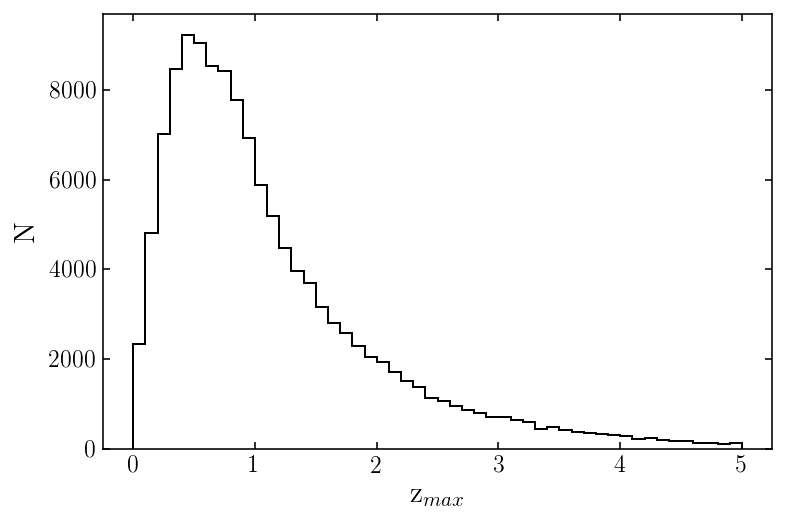

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(zmax, bins=50, range=(0,5), histtype='step', facecolor='None', edgecolor='Black')

ax.set_xlabel(r'z$_{max}$')
ax.set_ylabel('N')

plt.show()

In [19]:
# The main selection is just Z < 0.3 kpc
low_z_select = np.abs(data['Z']) < 0.3

# A more clever selection is Zmax < 0.5, appropriate [Fe/H] & [Mg/Fe]
thin_disk_metallicity_select_path = mpltPath.Path( np.array([x_selec_vals,y_selec_vals]).T )
thin_disk_metallicity_select = thin_disk_metallicity_select_path.contains_points( 
    np.array([data['FE_H'],data['MG_FE']]).T )
thin_disk_zmax_select = zmax.value < 0.5
thin_disk_select = thin_disk_zmax_select & thin_disk_metallicity_select

In [20]:
print( 'Low Z selection N: '+str(len( np.where(low_z_select)[0] )))
print( 'Thin disk metallicity selection N: '+str(len( np.where(thin_disk_select)[0] )))

Low Z selection N: 31439
Thin disk metallicity selection N: 29316


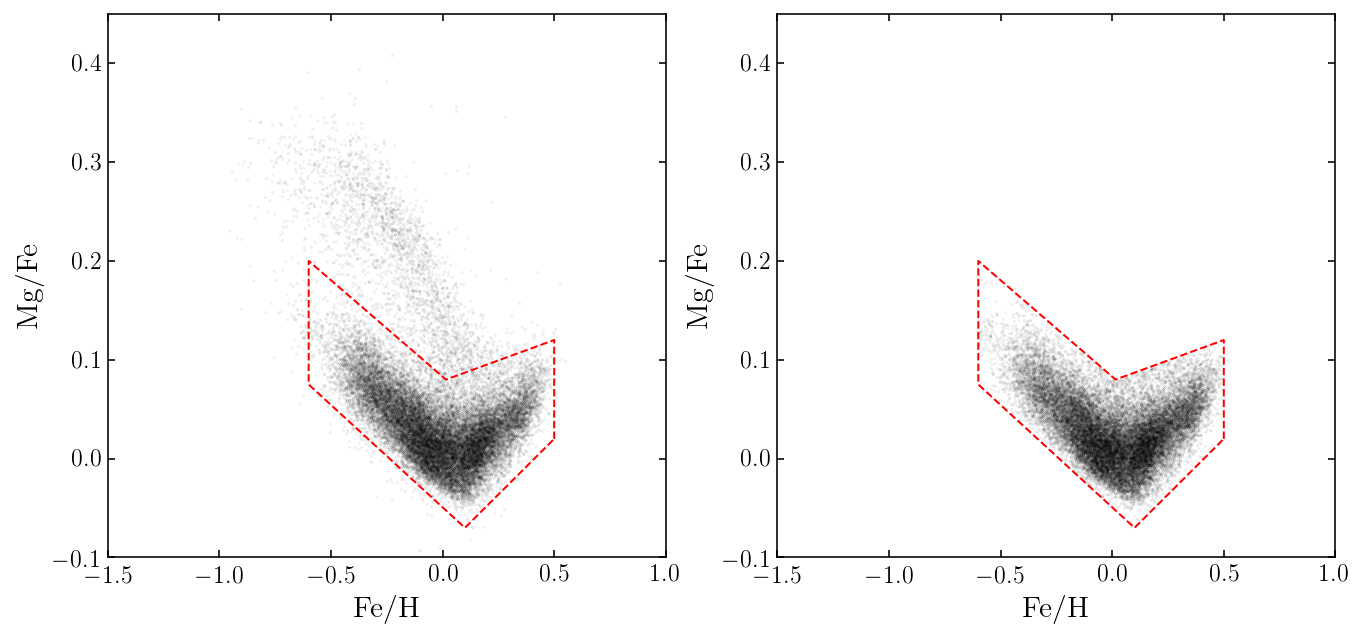

In [22]:
fig = plt.figure( figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter( data['FE_H'][low_z_select], data['MG_FE'][low_z_select], s=0.1, alpha=0.1, c='Black')
ax1.set_xlim(-1.5,1)
ax1.set_ylim(-0.1,0.45)
ax1.set_xlabel('Fe/H')
ax1.set_ylabel('Mg/Fe')

ax2.scatter( data['FE_H'][thin_disk_select], data['MG_FE'][thin_disk_select], s=0.1, alpha=0.1, c='Black')
ax2.set_xlim(-1.5,1)
ax2.set_ylim(-0.1,0.45)
ax2.set_xlabel('Fe/H')
ax2.set_ylabel('Mg/Fe')

fig.set_facecolor('White')

x_selec_vals = [0.50, 0.50, 0.015, -0.60, -0.60, 0.100, 0.50]
y_selec_vals = [0.02, 0.12, 0.080, 0.200, 0.075, -0.07, 0.02]
ax1.plot(x_selec_vals, y_selec_vals, color='Red', linestyle='dashed', linewidth=1.0)
ax2.plot(x_selec_vals, y_selec_vals, color='Red', linestyle='dashed', linewidth=1.0)

plt.show()

In [32]:
data_lowz = data[low_z_select]
data_td = data[thin_disk_select]
zmax_lowz = zmax[low_z_select]
zmax_td = zmax[thin_disk_select]
orbits_lowz = data_orbits[low_z_select]
orbits_td = data_orbits[thin_disk_select]

# Use Linear models to show velocity fields

## Set the grid parameters

In [34]:
# Radial bin range and size
R_lims = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/60
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2
vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy'

In [35]:
lm_lowz = ast1501.linear_model.LinearModel2(instantiate_method=1,
                                           gc_R=data_lowz['R'],
                                           gc_phi=data_lowz['PHI'],
                                           gc_vR=data_lowz['VR'],
                                           gc_vT=data_lowz['VT'],
                                           R_lims=R_lims,
                                           R_bin_size=R_bin_size,
                                           phi_lims=phi_lims, 
                                           phi_bin_size=phi_bin_size, 
                                           phib_lims=phib_lims,
                                           phib_bin_size=phib_bin_size, 
                                           vT_prior_path=vT_prior_path)

In [36]:
lm_td = ast1501.linear_model.LinearModel2(instantiate_method=1,
                                         gc_R=data_td['R'],
                                         gc_phi=data_td['PHI'],
                                         gc_vR=data_td['VR'],
                                         gc_vT=data_td['VT'],
                                         R_lims=R_lims,
                                         R_bin_size=R_bin_size,
                                         phi_lims=phi_lims, 
                                         phi_bin_size=phi_bin_size, 
                                         phib_lims=phib_lims,
                                         phib_bin_size=phib_bin_size, 
                                         vT_prior_path=vT_prior_path)

In [51]:
lowz_plot_kws = {'markeredgecolor':'DodgerBlue',
                 'ecolor':'DodgerBlue'}
td_plot_kws = {'markeredgecolor':'Red',
               'ecolor':'Red'}

plot_kws_all = {'fmt':'o',
               'markerfacecolor':'White',
               'capsize':4}

lowz_plot_kws.update(plot_kws_all)
td_plot_kws.update(plot_kws_all)

## Tangential Velocity

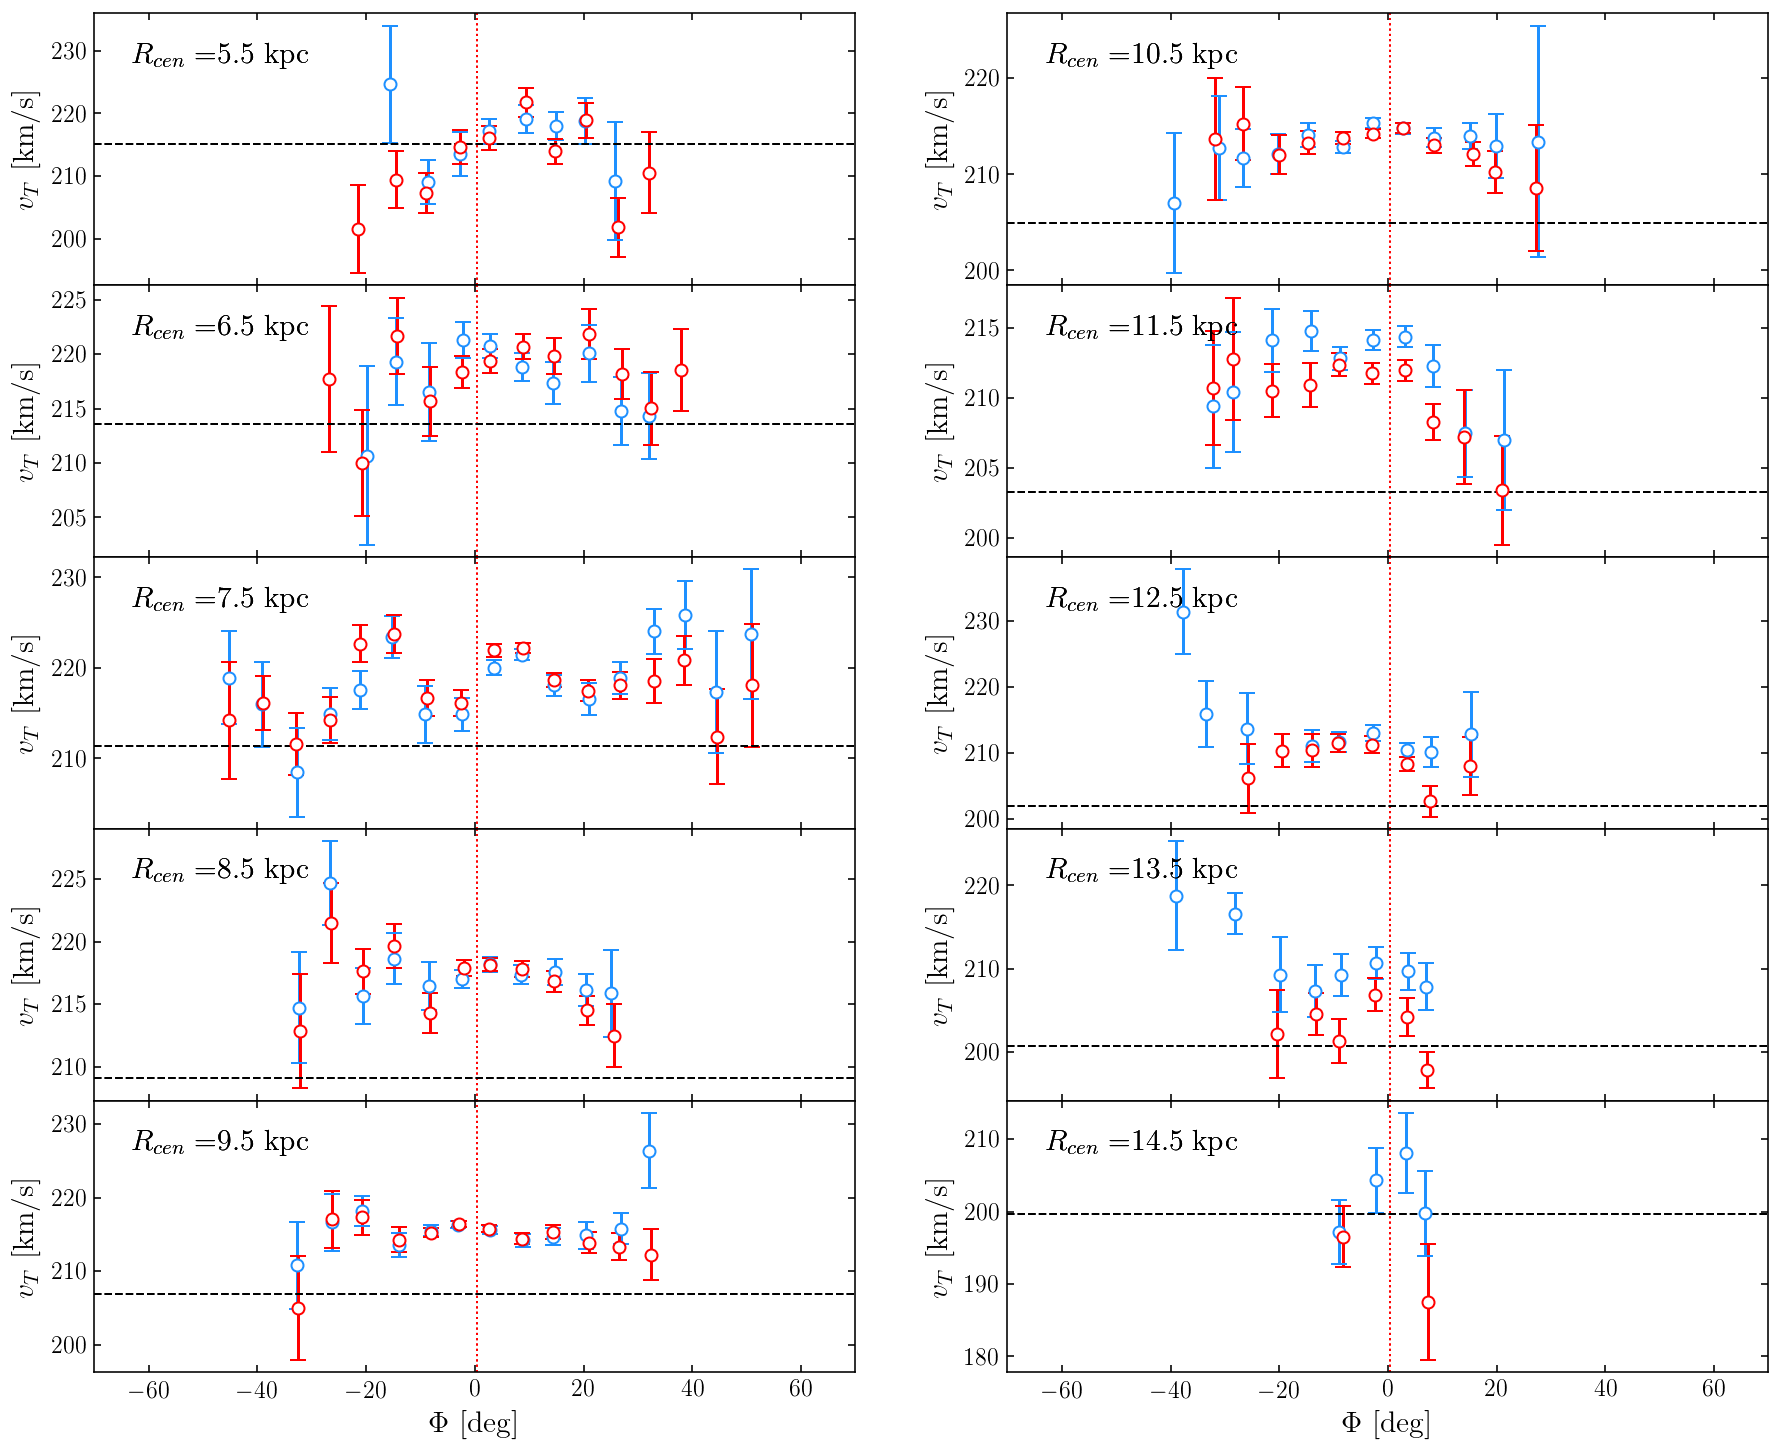

In [52]:
fig,axs = lm_lowz.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                              plot_kws=lowz_plot_kws, plot_degrees=True, phi_lim=[-70,70])
fig,axs = lm_td.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                            plot_kws=td_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

plt.show()

# Radial Velocity

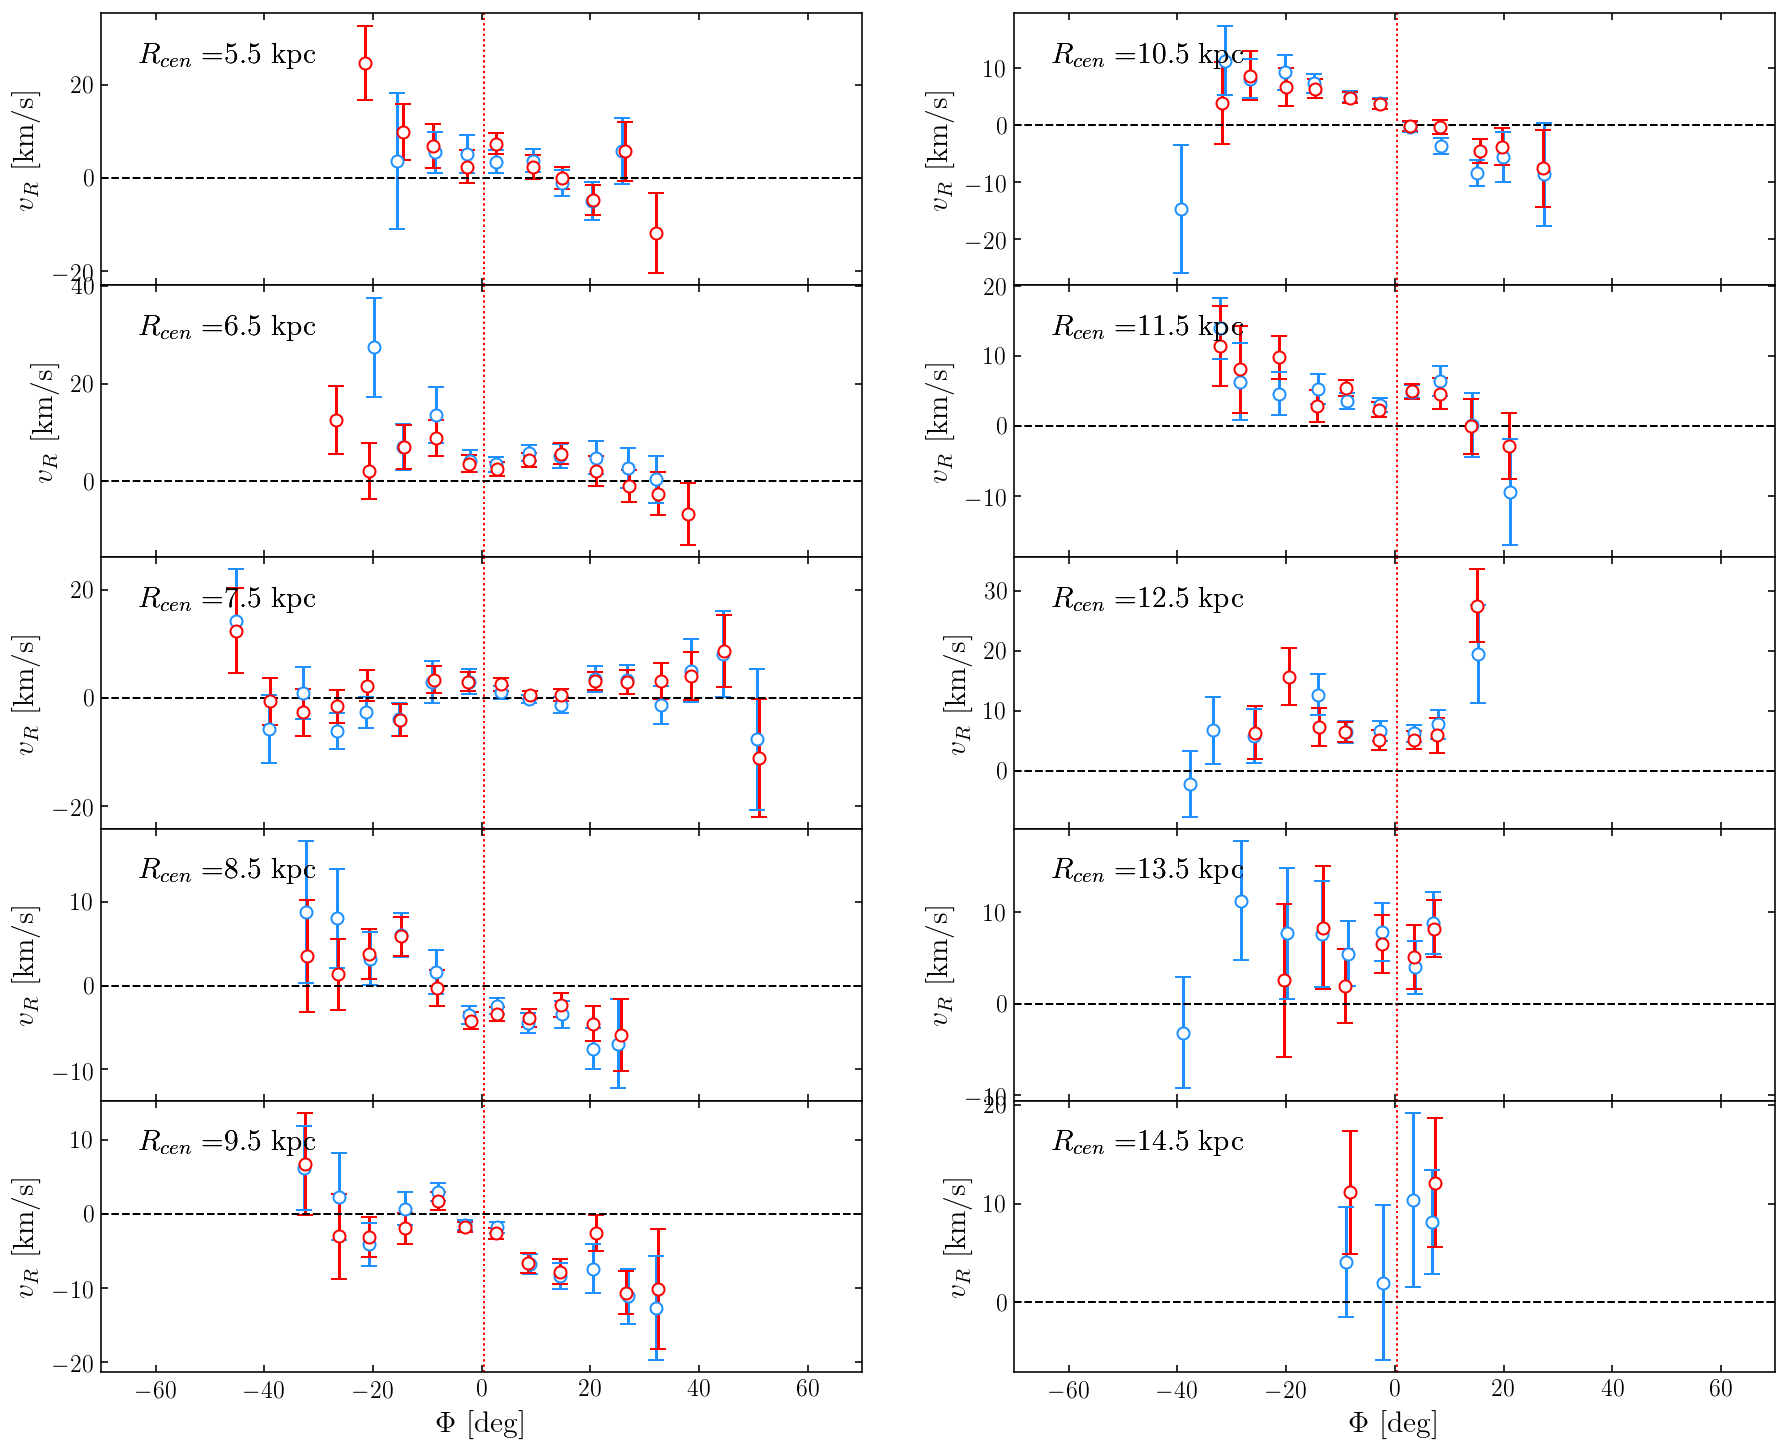

In [53]:
fig,axs = lm_lowz.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                              plot_kws=lowz_plot_kws, plot_degrees=True, phi_lim=[-70,70])
fig,axs = lm_td.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                            plot_kws=td_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

plt.show()

# Include some bars

In [54]:
lm_sfb = ast1501.linear_model.LinearModel2(instantiate_method=2, 
    df_filename='../../scripts/dehnen_method/bar_df/2019-05-20/data.npy', 
    phib_bin_size=phib_bin_size, phib_lims=phib_lims, 
    vT_prior_path=vT_prior_path)

lm_lsb = ast1501.linear_model.LinearModel2(instantiate_method=2, 
        df_filename='../../scripts/dehnen_method/lsbar_df/2019-05-27/data.npy', 
        phib_bin_size=phib_bin_size, phib_lims=phib_lims,
        vT_prior_path=vT_prior_path)

In [55]:
sfb_plot_kws={'facecolor':'DarkGreen',}
lsb_plot_kws={'facecolor':'Purple',}

plot_kws_all = {'alpha':0.5, 's':4}

sfb_plot_kws.update(plot_kws_all)
lsb_plot_kws.update(plot_kws_all)

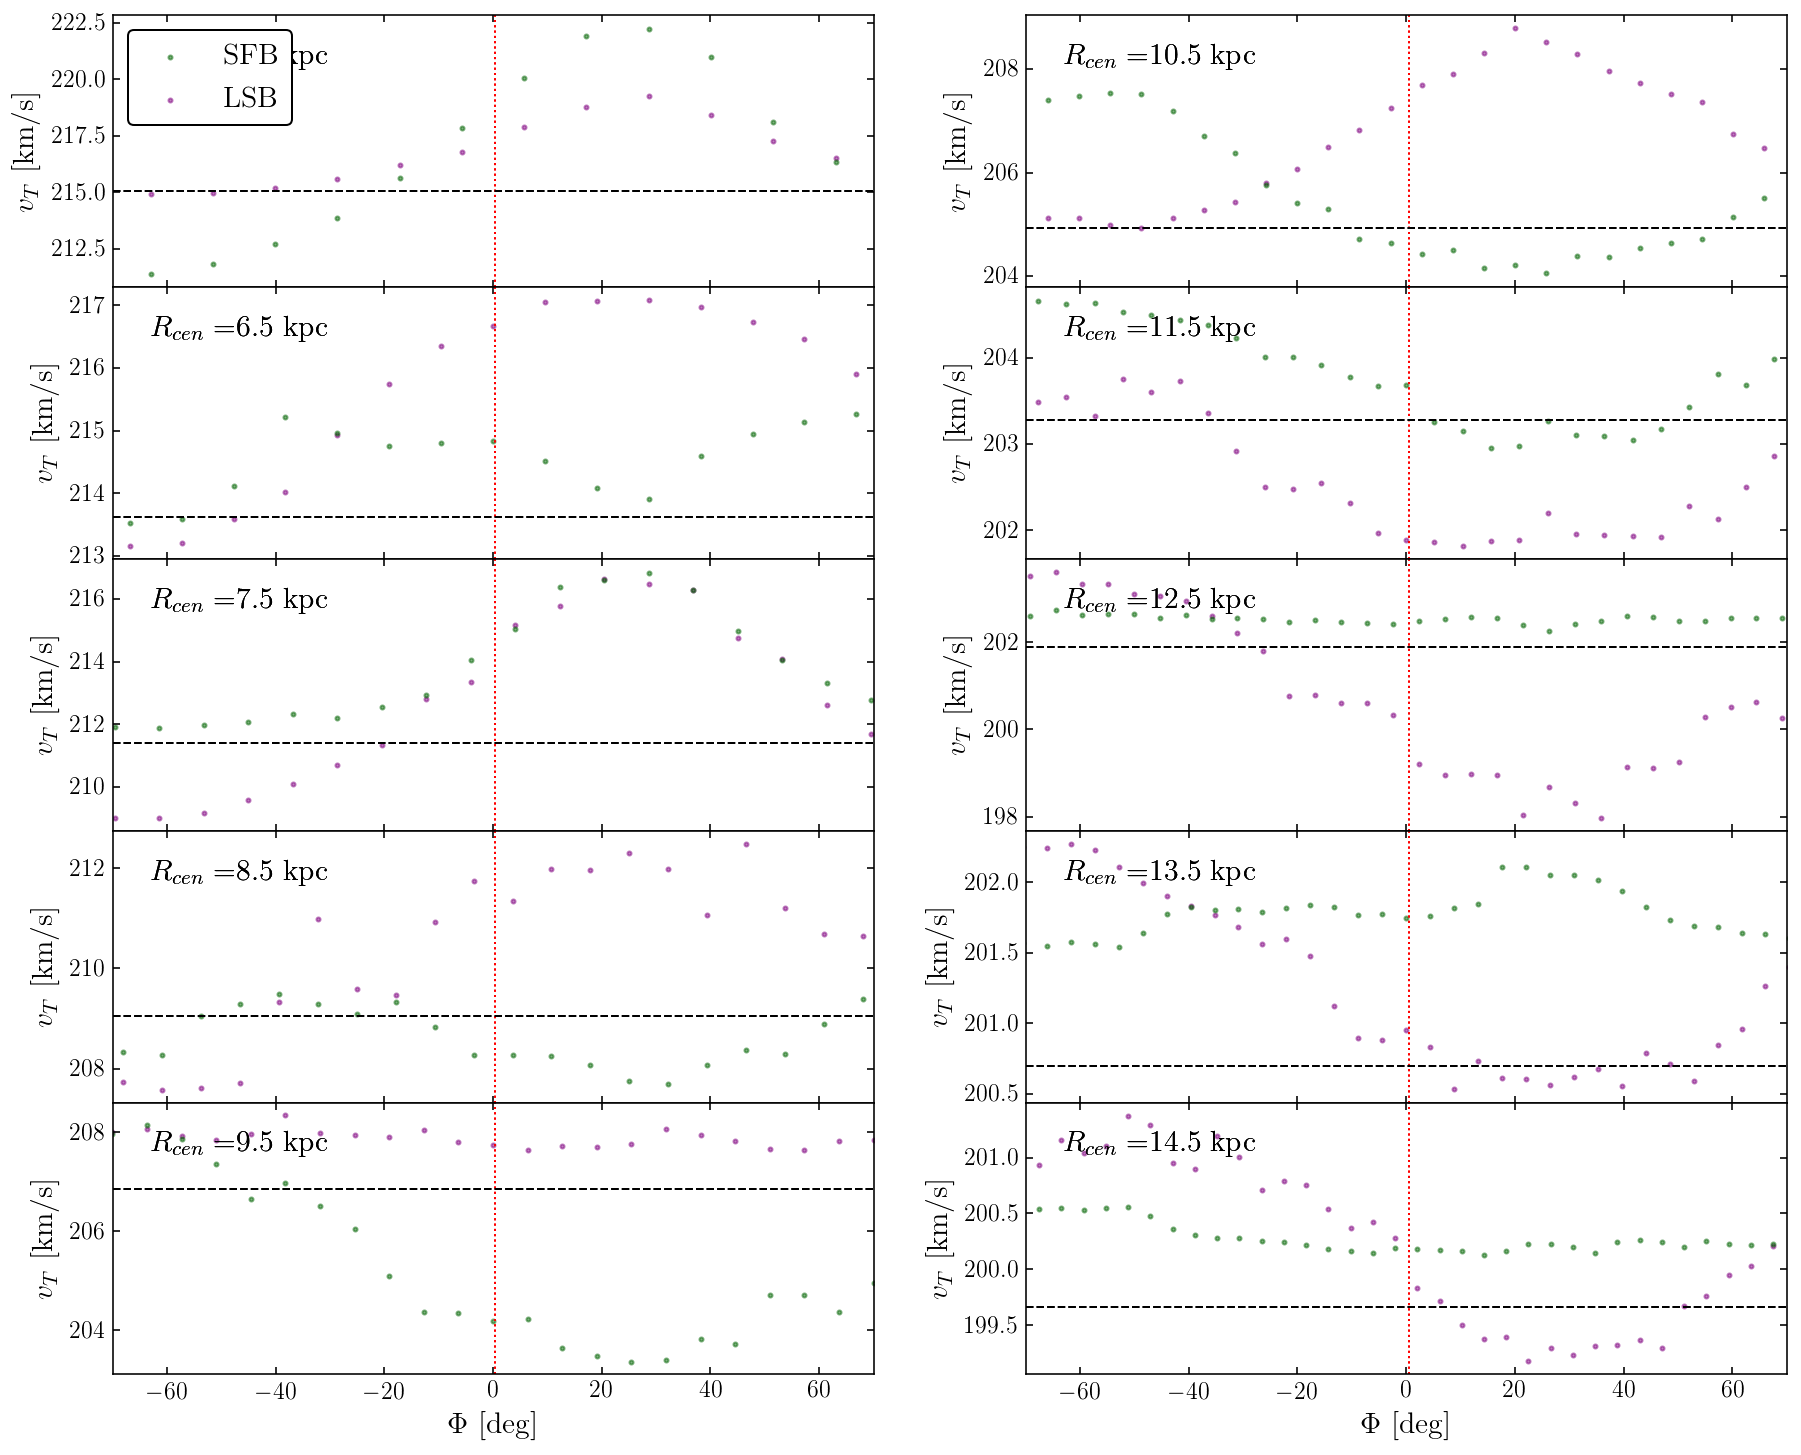

In [59]:
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                              plot_kws=lsb_plot_kws, plot_degrees=True, phi_lim=[-70,70])
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                            plot_kws=sfb_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

sfb_pts=axs[0].scatter([],[],**sfb_plot_kws)
lsb_pts=axs[0].scatter([],[],**lsb_plot_kws)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
plt.show()

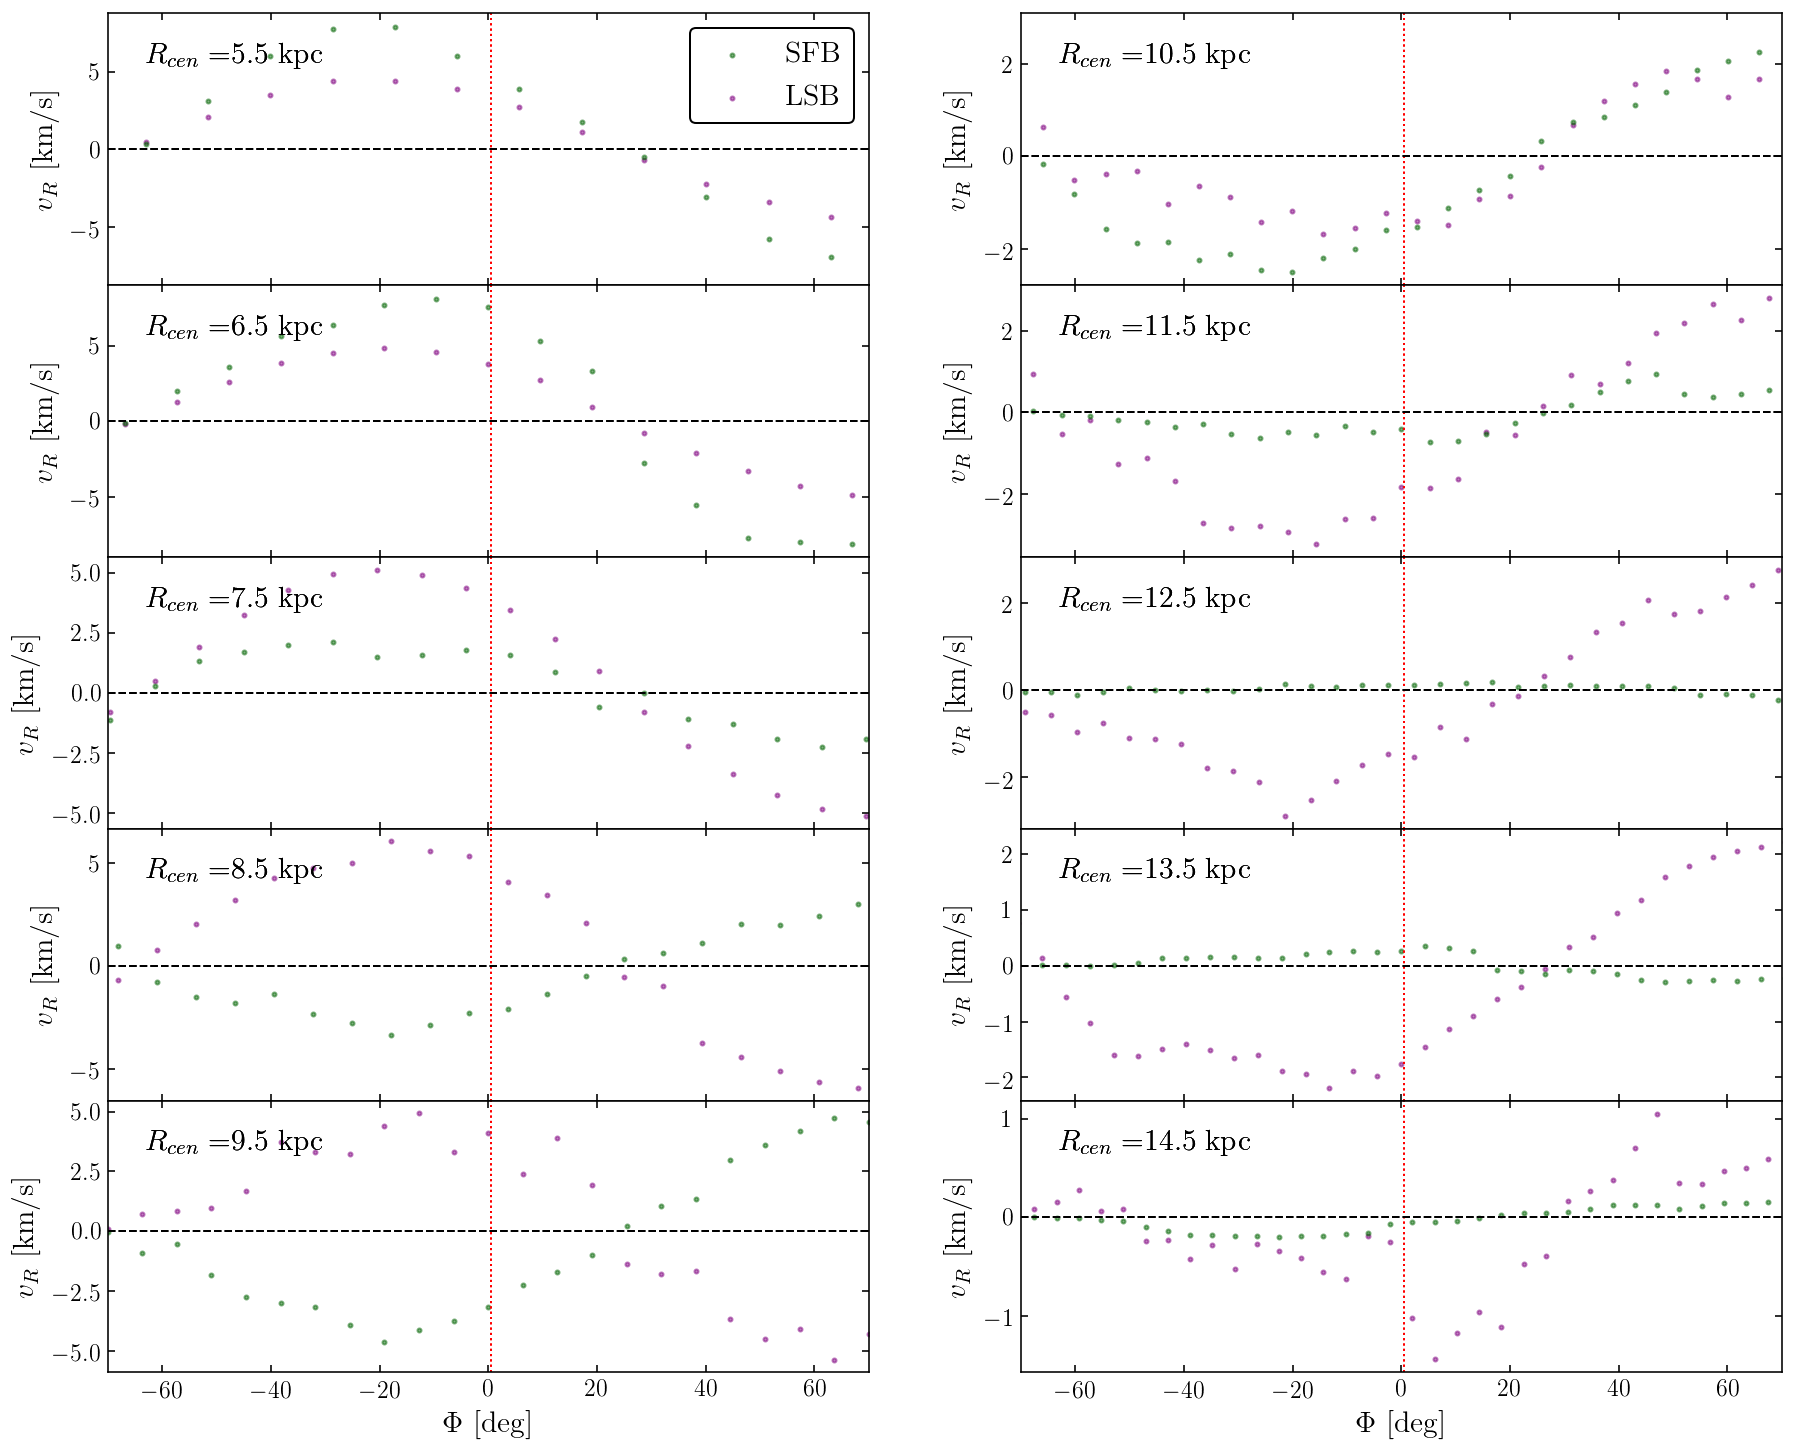

In [60]:
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                              plot_kws=lsb_plot_kws, plot_degrees=True, phi_lim=[-70,70])
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                            plot_kws=sfb_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

sfb_pts=axs[0].scatter([],[],**sfb_plot_kws)
lsb_pts=axs[0].scatter([],[],**lsb_plot_kws)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
plt.show()

# Show with the data

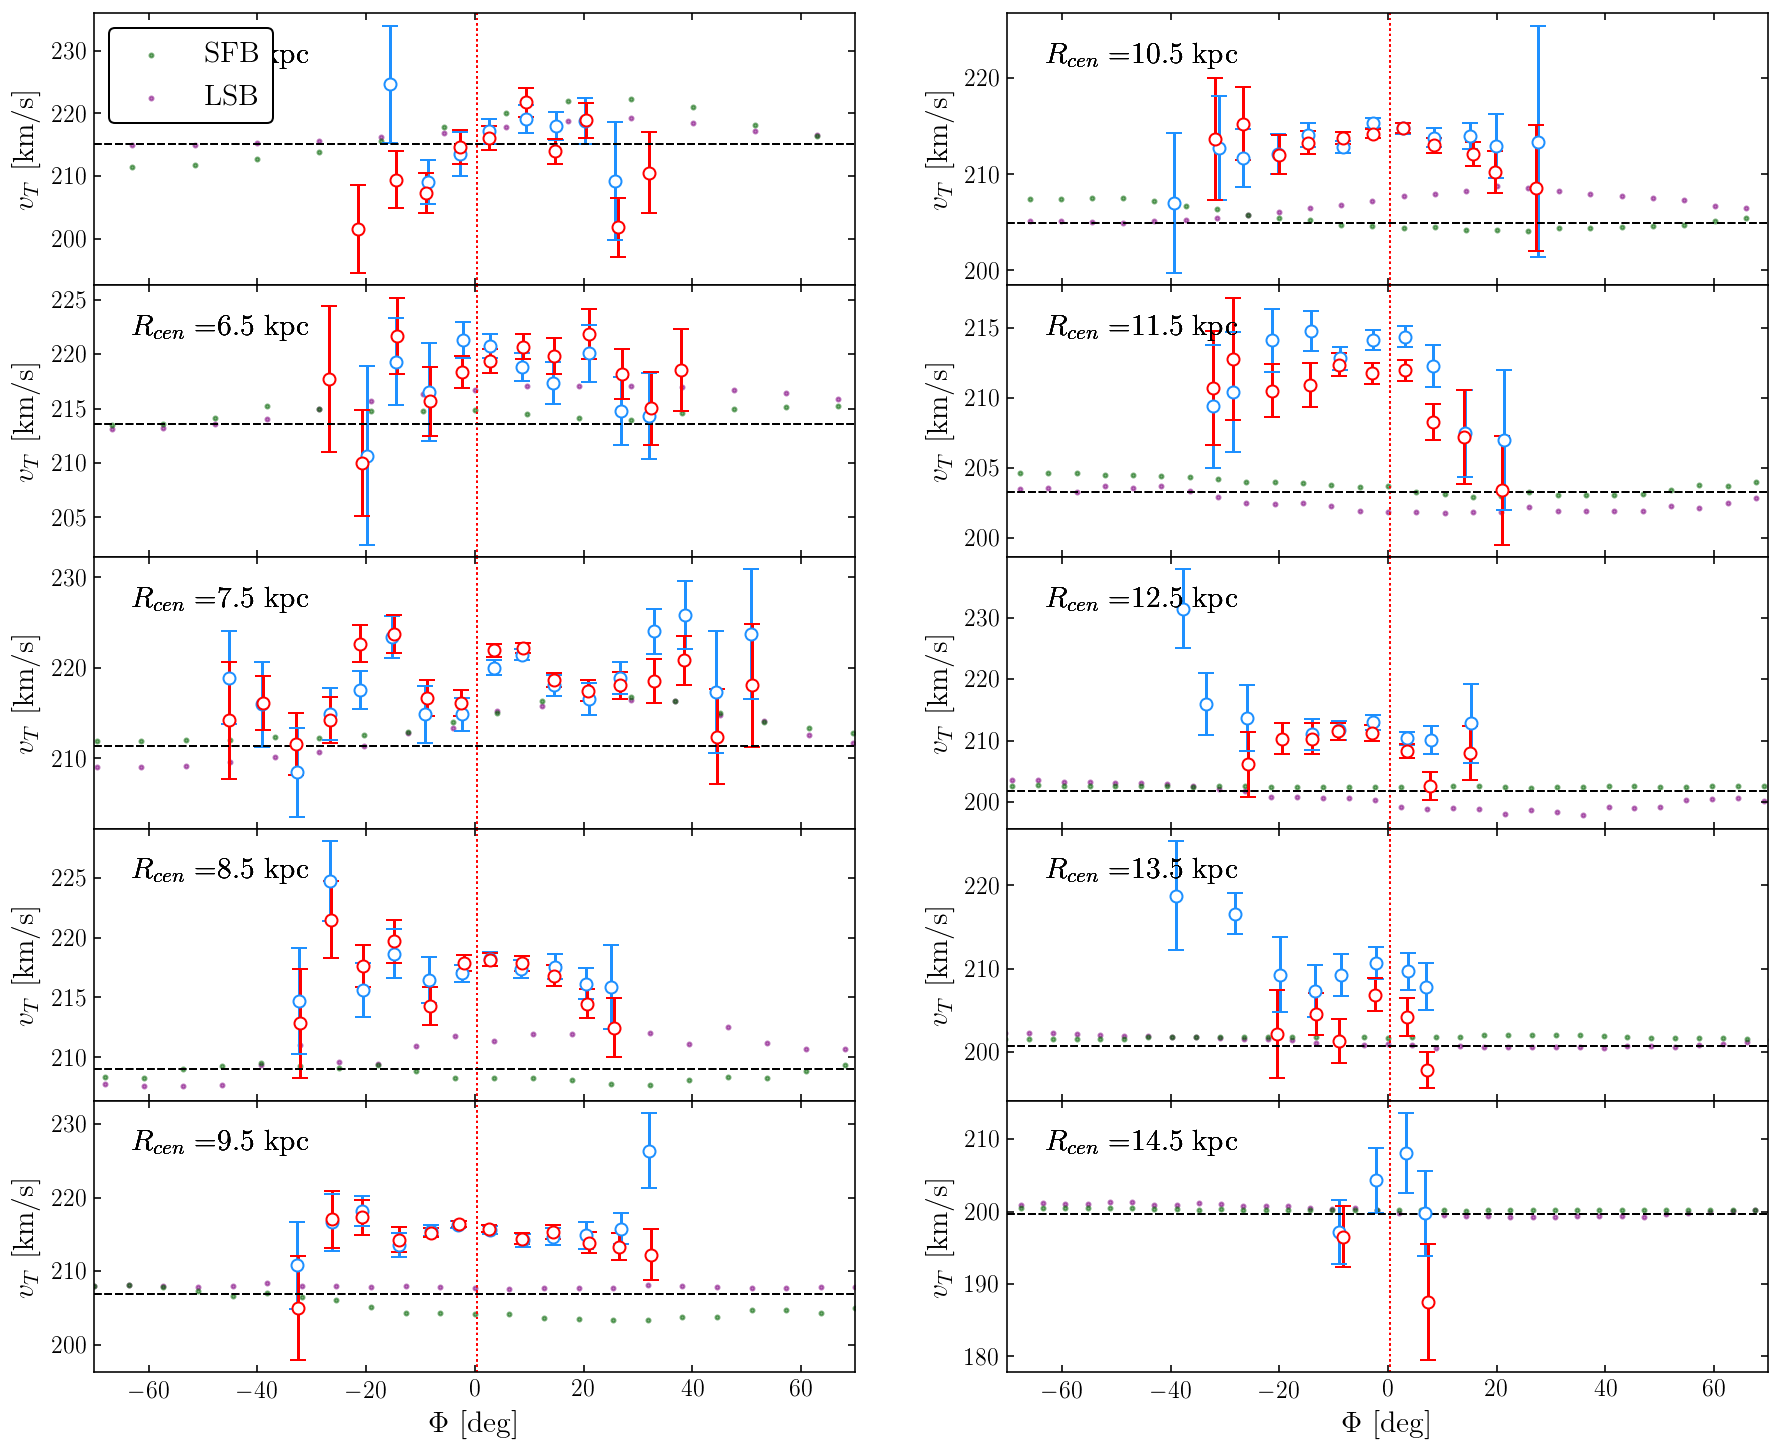

In [62]:
fig,axs = lm_lowz.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                              plot_kws=lowz_plot_kws, plot_degrees=True, phi_lim=[-70,70])
fig,axs = lm_td.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                            plot_kws=td_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                              plot_kws=lsb_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                            plot_kws=sfb_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

sfb_pts=axs[0].scatter([],[],**sfb_plot_kws)
lsb_pts=axs[0].scatter([],[],**lsb_plot_kws)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
plt.show()

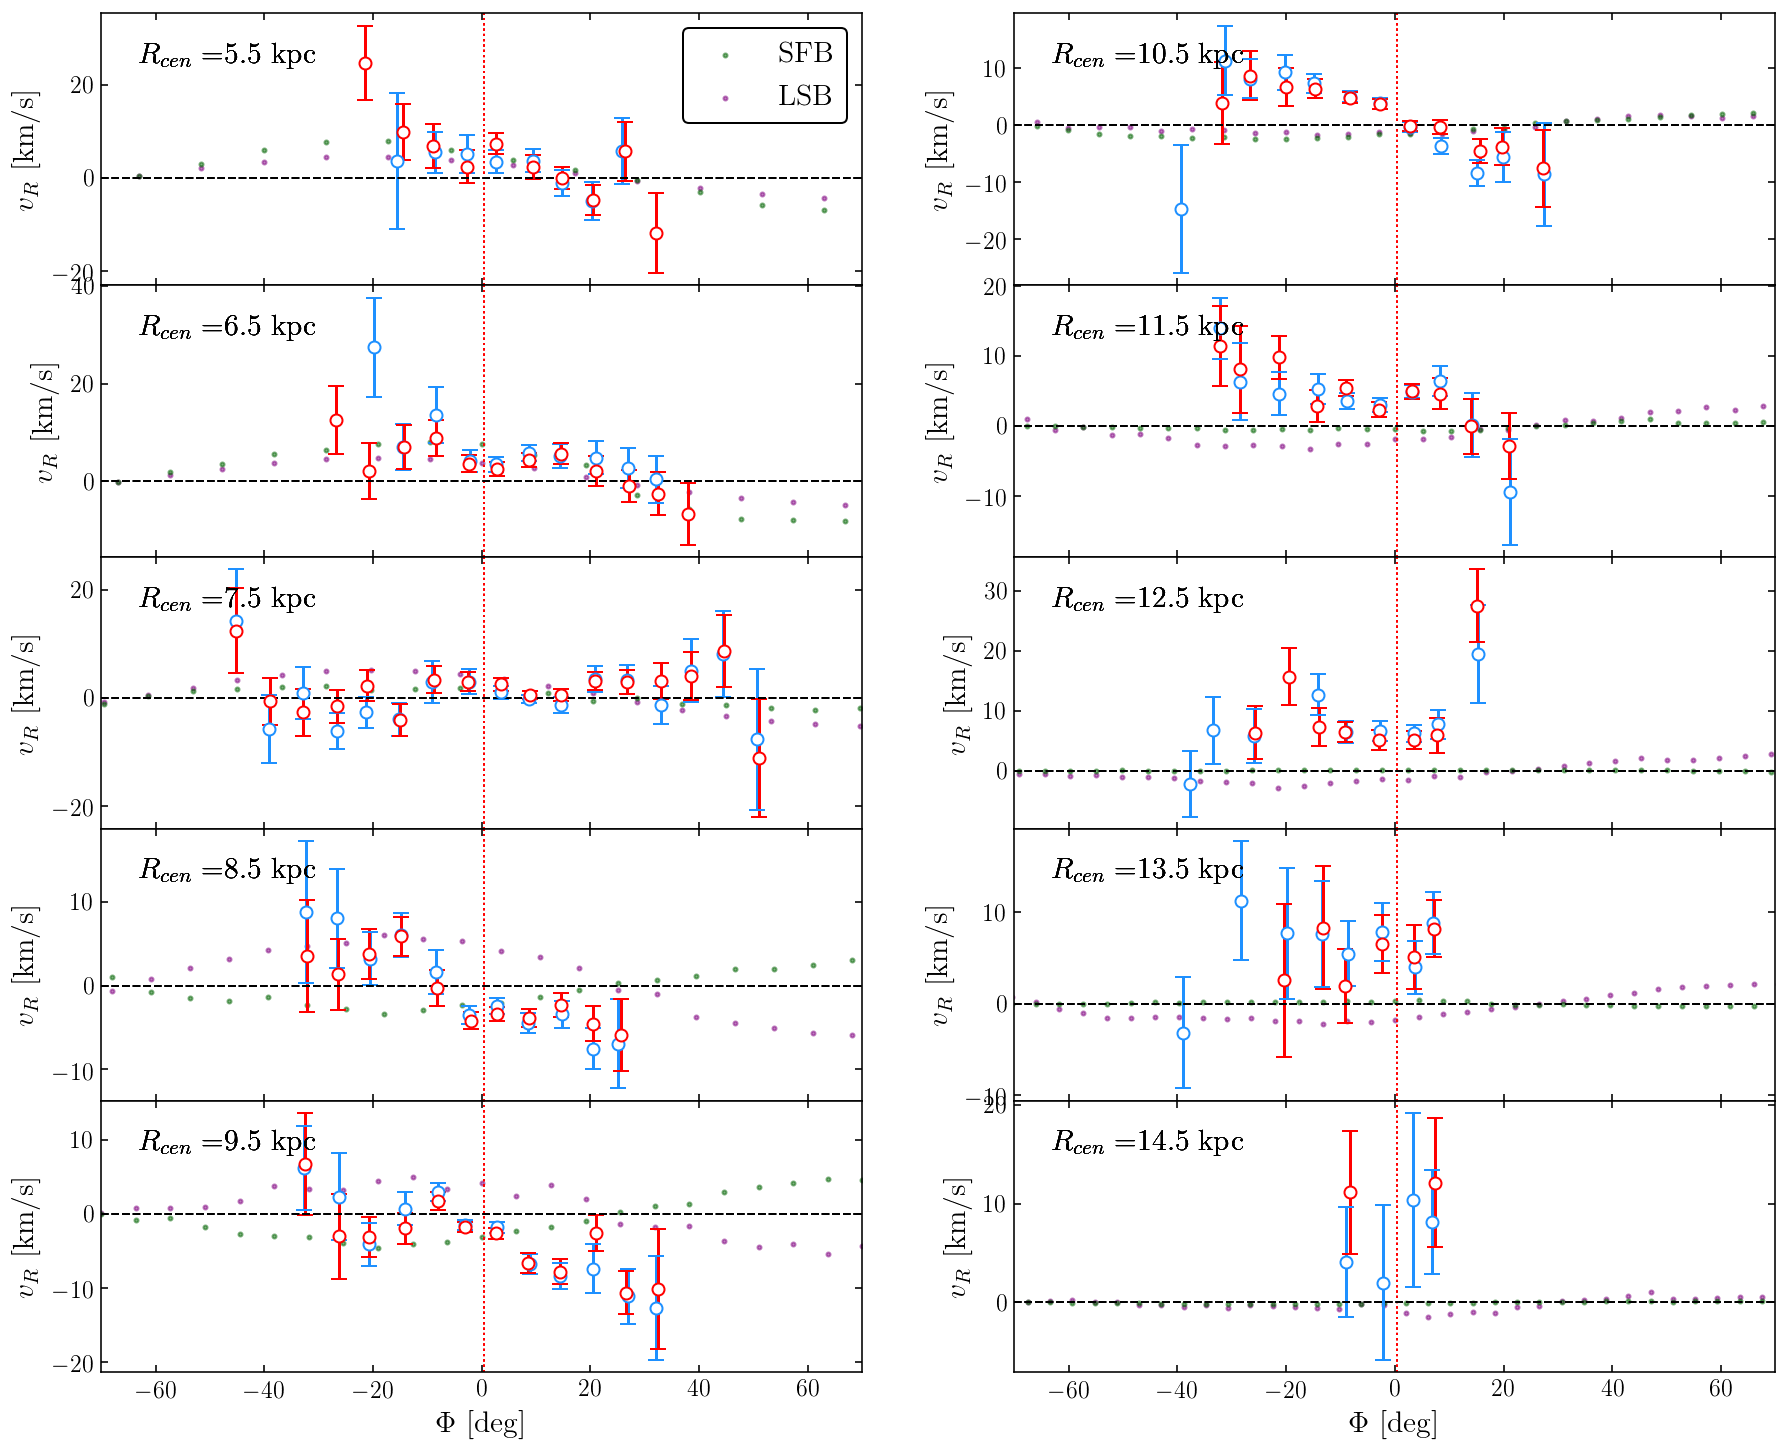

In [61]:
fig,axs = lm_lowz.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                              plot_kws=lowz_plot_kws, plot_degrees=True, phi_lim=[-70,70])
fig,axs = lm_td.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=True,
                                            plot_kws=td_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                              plot_kws=lsb_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, twocolumn=True, plot_errs=False,
                                            plot_kws=sfb_plot_kws, plot_degrees=True, phi_lim=[-70,70], fig=fig, axs=axs)

sfb_pts=axs[0].scatter([],[],**sfb_plot_kws)
lsb_pts=axs[0].scatter([],[],**lsb_plot_kws)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
plt.show()